<a href="https://colab.research.google.com/github/AlexTsikhun/t-spark-ml-test/blob/main/t-spark_prepare_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare COCO dataset of a specific (human and car) subset of classes
Install COCO dataset (annotations and images)

In [1]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip -q /content/annotations_trainval2014.zip

--2023-08-27 09:12:56--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.234.241, 52.216.140.68, 52.216.110.163, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.234.241|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  98.7MB/s    in 2.4s    

2023-08-27 09:12:59 (98.7 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]



In [2]:
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip -q /content/train2014.zip

--2023-08-27 09:13:13--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.71.124, 52.217.134.169, 52.217.254.1, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.71.124|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  48.5MB/s    in 5m 13s  

2023-08-27 09:18:27 (41.1 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]



In [3]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip -q /content/val2014.zip

--2023-08-27 09:24:35--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.192.161, 52.217.167.113, 52.216.160.171, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.192.161|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.19G  39.2MB/s    in 2m 23s  

2023-08-27 09:26:58 (44.2 MB/s) - ‘val2014.zip’ saved [6645013297/6645013297]



In [4]:
# for debugging
! pip install -q icecream

In [10]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import numpy as np
import shutil
import torch
import cv2
import os
from icecream import ic

Delete redundant .zip for less memory usage

In [39]:
os.remove('/content/train2014.zip')
os.remove('/content/val2014.zip')
os.remove('/content/annotations_trainval2014.zip')

Create proper folder structure for YOLO

In [6]:
root_dir = '/content/data'
subdir = ['annot/train',
          'annot/validation',
          'images/train',
          'images/validation']
if not os.path.exists(root_dir):
  os.makedirs(root_dir)

for subd in subdir:
  full_path = os.path.join(root_dir, subd)
  os.makedirs(full_path)

Loading annotations

In [7]:
train_annotations = COCO("/content/annotations/instances_train2014.json")
valid_annotations = COCO("/content/annotations/instances_val2014.json")

cat_ids = train_annotations.getCatIds(supNms=["person", "car"])

train_img_ids = []
for cat in cat_ids:
    train_img_ids.extend(train_annotations.getImgIds(catIds=cat))

train_img_ids = list(set(train_img_ids))
print(f"Number of training images: {len(train_img_ids)}")

valid_img_ids = []
for cat in cat_ids:
    valid_img_ids.extend(valid_annotations.getImgIds(catIds=cat))

valid_img_ids = list(set(valid_img_ids))
print(f"Number of validation images: {len(valid_img_ids)}")

loading annotations into memory...
Done (t=16.76s)
creating index...
index created!
loading annotations into memory...
Done (t=7.85s)
creating index...
index created!
Number of training images: 45174
Number of validation images: 21634


In [8]:
# Filling with images and annot. training folder
root_path = '/content/train2014'
_type = 'train'

for img_ids in tqdm(train_img_ids):

    img_data = train_annotations.loadImgs(img_ids)
    files = [str(root_path + '/' + img["file_name"]) for img in img_data]

    ann_ids = train_annotations.getAnnIds(
            imgIds=img_data[0]['id'],
            catIds=cat_ids,
            iscrowd=None
        )
    anns = train_annotations.loadAnns(ann_ids)
    mask = torch.LongTensor(np.max(np.stack([train_annotations.annToMask(ann) * ann["category_id"]
                                                 for ann in anns]), axis=0)).unsqueeze(0)


    x_arr = mask.squeeze().cpu().detach().numpy()
    temp_str = files[0].split('/')[-1].replace('.jpg', '.png')
    cv2.imwrite(f"/content/data/annot/{_type}/{temp_str}", x_arr)

    src = files[0]
    # ic(mask)
    dest = f'/content/data/images/{_type}'
    shutil.copy(src, dest)


100%|██████████| 45174/45174 [08:18<00:00, 90.56it/s] 


In [9]:
# Filling validation folder
_type = 'validation'
root_path = 'val2014'

for img_ids in tqdm(valid_img_ids):

    img_data = valid_annotations.loadImgs(img_ids)
    files = [str(root_path + '/' + img["file_name"]) for img in img_data]

    ann_ids = valid_annotations.getAnnIds(
            imgIds=img_data[0]['id'],
            catIds=cat_ids,
            iscrowd=None
        )

    anns = valid_annotations.loadAnns(ann_ids)
    mask = torch.LongTensor(np.max(np.stack([valid_annotations.annToMask(ann) * ann["category_id"]
                                                 for ann in anns]), axis=0)).unsqueeze(0)


    x_arr = mask.squeeze().cpu().detach().numpy()
    temp_str = files[0].split('/')[-1].replace('.jpg', '.png')
    cv2.imwrite(f"/content/data/annot/{_type}/{temp_str}", x_arr)

    src = files[0]
    dest = f'/content/data/images/{_type}'
    shutil.copy(src, dest)

100%|██████████| 21634/21634 [03:47<00:00, 94.97it/s] 


In [ ]:
# can delete annotations folder, train2014 and val2014

In [24]:
def plot_imgs(image_path1, image_path2):
  """
    Show annotations and images
    Parameters:
      image_path1 (str): Path to the first image.
      image_path2 (str): Path to the second image.
  """
  img1 = mpimg.imread(image_path1)
  img2 = mpimg.imread(image_path2)

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(img1)
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.imshow(img2)
  plt.axis('off')
  plt.show()

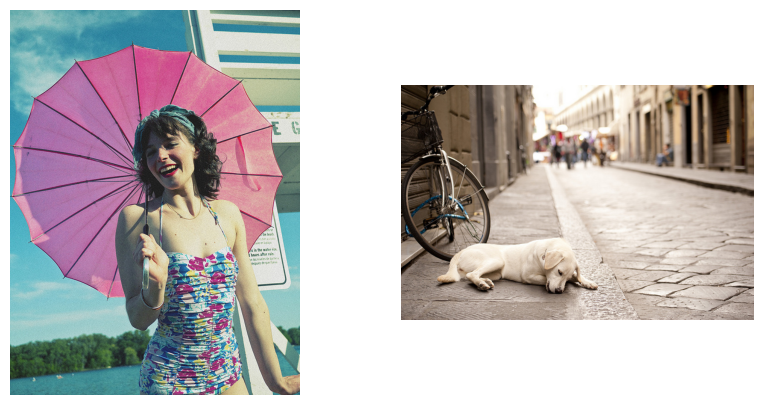

In [25]:
train_image_path = '/content/data/images/train/COCO_train2014_000000000036.jpg'
val_image_path = '/content/data/images/validation/COCO_val2014_000000000074.jpg'
plot_imgs(train_image_path, val_image_path)

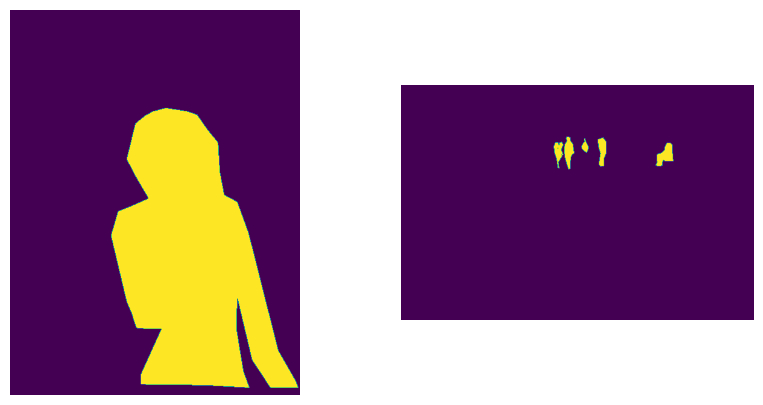

In [26]:
train_annot_path = '/content/data/annot/train/COCO_train2014_000000000036.png'
val_annot_path = '/content/data/annot/validation/COCO_val2014_000000000074.png'
plot_imgs(train_annot_path, val_annot_path)

Save to Google Drive zipped archive of filtered data

In [30]:
# Mount, connect drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import shutil
# zipping
source_folder_path = '/content/data'
zip_filename = '/content/filtered_data'

shutil.make_archive(zip_filename, 'zip', source_folder_path)

'/content/filtered_data.zip'

In [48]:
# moving archive to drive
destination_folder_path = '/content/drive/MyDrive/'

shutil.move(f"{zip_filename}.zip", destination_folder_path)

'/content/drive/MyDrive/filtered_data.zip'

In [52]:
os.remove(f"/content/{zip_filename}.zip")